---
title: "Day 1 - ImageNet Classification with Deep Convolutional Neural Networks"
author: "Jax Bulbrook"
date: "2023-07-18"
categories: [100-papers]
---

# Summary
They trained a convolutional neural network to identify ImageNet with state of the art results. The model consists of 5 convolutional layers, and then 3 feed-forward layers, with maxpooling and response-normalization layers in between. The main problems were overfitting and runtime, which were solved using data augmentation and ReLU Nonlinearity.

# Takeaway
I need to understand how to implement a custom model like this. I am taking the FastAI course, so I thought I knew what I was doing, but I need a deeper understanding. I think I am going to just do PyTorch for a while to learn the fundamentals, and maybe try to recreate this model on a smaller scale. Convolutional models are very interesting, I wonder if they work for NLP as well. I also wonder if there is a better way to make hyper-parameters. Maybe training a model to predict hyperparameters would be a good idea.

# Other research
I need to study the math side more, as I didn't understand the equations very easily. I am going to take a calculus course then a linear algebra course to familiarize myself. I also want to learn about Fisher Vectors, eigenvectors, and principal component analysis. Learning about other optimization methods rather than SGD, like Adam, sounds interesting as well.

# My attempt to implement it (not fully trained, just a smaller dataset called CIFAR 10)
## First portion, learning via just FashionMNIST. Skip this, I am just including it to show beginners that I too don't know what I'm doing

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [7]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


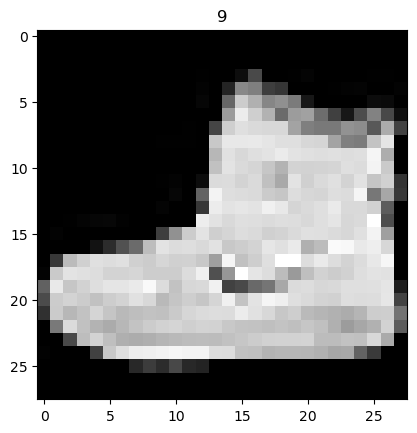

In [38]:
# plot an example of the data
import matplotlib.pyplot as plt
plt.imshow(training_data.data[0], cmap='gray')
plt.title('%i' % training_data.targets[0])
plt.show()

In [39]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [40]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [48]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential( # a convolution, then an activation function, then a maxpool
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_stack_2 = nn.Sequential( # a convolution, then an activation function, then a maxpool
            nn.Conv2d(16, 32, 5),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(64, 512) # fully connected layer

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.conv_stack_2(x)
        x = x.view(x.size(0), -1) # flatten the output to allow for a linear layer (lines up the data along 1d vector
        output = self.out(x)
        return output

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=64, out_features=512, bias=True)
)


In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader): #X,y is images,labels
        X, y = X.to(device), y.to(device)
 #X,y is images,labels
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 100 == 0:
         #   loss, current = loss.item(), (batch + 1) * len(X)
          #  print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [31]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [52]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 64x512)

#### I tried, but I couldn't figure out why two matrices of the same size couldn't be multipled. I just moved on as I had what I needed anyway.
# Training on CIFAR 10 (Pytorch default ConvNet)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

/home/jaxbulbrook/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# initial setup - getting and putting data into dataloaders
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalized so that the data ranges from -0.5 to 0.5 rather than 0 to 1

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|████████████████████████| 170498071/170498071 [00:25<00:00, 6785202.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


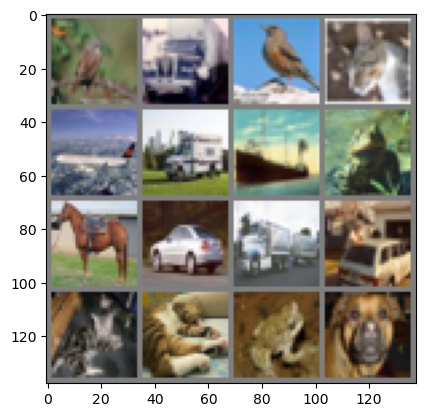

bird  truck bird  cat   plane truck ship  frog  horse car   truck car   cat   cat   frog  dog  


In [9]:
# visualizing the data
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16],4))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# The model itself, where the experiment happens
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [14]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=2d4e54895a5f65494e3abe2977fb69c8874ac65d79685a8c325723e4dd999f64
  Stored in directory: /home/jaxbulbrook/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [15]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  5% | 23% |


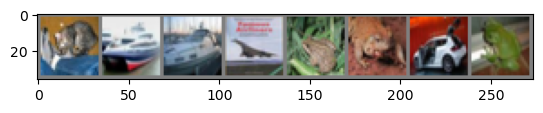

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [25]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [26]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  cat   ship  ship  ship  cat   frog  car   deer 


In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 47 %


# Research paper implementation
The papers implemeted techniques are all already in there, not technologically feasible (multiple GPUs), or would not work on smaller data. The only thing I can change is data augmentation. The state of the art 10 years ago is the average now, wow!